# Setup

In [57]:
jsoc_email = "hudson.harner657@topper.wku.edu"

In [58]:
%matplotlib inline
import sunpy
import aiapy
import aiapy.data.sample as sample_data
from aiapy.calibrate import normalize_exposure, register, update_pointing
import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
import scipy

#Set default fig size for matplotlib
plt.rcParams['figure.figsize'] = [8, 8]
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
import datetime
#import ffmpeg
#import torch

# Flare Confirmation

In [59]:
#Search for flares given minimum magnitude (C1.0) and time interval
results = Fido.search(a.Time('2022-01-25', '2022-01-26'), a.hek.FL, a.hek.FL.GOESCls > "C1.0")
results.show()

gs_thumburl,comment_count,hpc_bbox,frm_humanflag,hgc_coord,event_coordsys,obs_levelnum,hpc_coord,event_npixels,gs_imageurl,ar_polarity,frm_paramset,hrc_coord,event_starttime,ar_mtwilsoncls,event_type,intensmin,fl_fluence,obs_meanwavel,frm_url,skel_chaincode,bound_chaincode,noposition,fl_fluenceunit,active,intensmax,frm_versionnumber,fl_peaktempunit,fl_halphaclass,area_uncert,obs_dataprepurl,hpc_geom,hgc_bbox,intensmedian,chaincodetype,obs_channelid,event_clippedspatial,ar_noaaclass,SOL_standard,event_avg_rating,eventtype,intensunit,hpc_boundcc,event_mapurl,frm_contact,ar_penumbracls,intensmean,bound_ccstartc1,frm_name,area_atdiskcenter,frm_identifier,obs_observatory,event_description,boundbox_c2ur,obs_firstprocessingdate,boundbox_c2ll,frm_institute,hrc_bbox,refs_orig,ar_mcintoshcls,event_maskurl,bound_ccstartc2,gs_movieurl,event_score,skel_startc2,skel_startc1,fl_efoldtime,event_expires,fl_efoldtimeunit,hrc_boundcc,event_probability,intensvar,frm_daterun,event_coordunit,hpc_y,hpc_x,search_instrument,ar_numspots,kb_archivdate,kb_archivist,intenstotal,sum_overlap_scores,hgs_boundcc,intensskew,obs_includesnrt,rasterscan,obs_wavelunit,kb_archivid,search_frm_name,boundbox_c1ur,ar_noaanum,area_atdiskcenteruncert,boundbox_c1ll,event_importance_num_ratings,ar_compactnesscls,skel_curvature,event_testflag,event_c2error,hrc_r,skel_nsteps,hgs_y,obs_title,fl_peakemunit,hgs_x,hcr_checked,frm_specificid,event_title,obs_instrument,event_c1error,revision,hpc_radius,event_endtime,event_importance,event_coord2,event_coord3,event_coord1,search_observatory,area_raw,concept,event_pixelunit,hgc_boundcc,fl_peakflux,hgc_x,hrc_a,event_peaktime,hgc_y,gs_galleryid,fl_goescls,hgs_coord,ar_zurichcls,bound_ccnsteps,intenskurt,event_clippedtemporal,fl_peakfluxunit,fl_peakem,rasterscantype,search_channelid,fl_peaktemp,hgs_bbox,area_unit,obs_lastprocessingdate,refs
str131,str1,str115,str5,str19,str12,object,str28,object,str130,object,str57,str41,str19,str1,str2,object,object,float64,str82,str1,str1,str5,str1,str4,object,object,str1,str1,object,str1,str186,str85,object,str1,str3,str1,str1,str30,object,str1,str1,str1,str1,str23,str1,object,object,str17,object,str9,str4,str1,float64,str1,float64,str61,str110,str1,str1,str1,object,str99,str20,object,object,object,str1,str1,str1,object,object,str19,str7,float64,float64,str4,object,str19,str19,object,str1,str1,object,str1,str1,str2,str66,str17,float64,int32,object,float64,str1,str1,object,str5,int32,float64,object,int32,str1,str1,int32,str4,str1,str1,str4,int32,str1,str19,str19,object,int32,object,int32,str4,object,str5,str1,str1,object,float64,float64,str19,int32,str1,str4,str13,str1,object,object,str1,str1,object,str1,str19,object,str66,str1,str1,object
,0,"POLYGON((-1.700701 -970.08462,1.700701 -970.08462,1.699337 969.21102,-1.699337 969.21102,-1.700701 -970.08462))",false,POINT(-176.49438 0),UTC-HGS-TOPO,None,POINT(0 93.41928),None,,None,"SSWIDL get_gev, ..., ngdc=0",POINT(0.095903494101659 0),2022-01-25T05:34:00,,FL,None,None,5e-08,http://www.swpc.noaa.gov/,,,true,,true,None,None,,,None,,,"POLYGON((93.60562 -89.9,-86.59438 -89.9,-86.59438 89.9,93.60562 89.9,93.60562 -89.9))",None,,XRA,,,SOL2022-01-25T05:34:00L184C090,None,9,,,,SWPC.Webmaster@noaa.gov,,None,None,SWPC,None,SWPC,GOES,,89.9000015258789,,-89.9000015258789,"U.S. Dept. of Commerce, NOAA, Space Weather Prediction Center","POLYGON((0.995883 179.899552,0.995883 180.100448,0.994986 359.899542,0.994986 0.100458,0.995883 179.899552))",,,,None,,0.442000000000000004,None,None,None,,,,None,None,2022-01-25T00:00:00,degrees,93.41928,0.0,GOES,None,2022-05-25T15:58:14,autosubmission_swpc,None,0,,None,,,cm,ivo://helio-informatics.org/FL_SWPC_20220525_155812_20220125053400,SWPC,89.9000015258789,0,None,-89.9000015258789,,,None,false,90,0.095903494101659,None,0,,,0,true,,,GOES,90,1,93.4192800000000005,2022-01-25T06:05:00,None,0,None,0,GOES,None,Flare,,,None,-176.49438,0.0,2022-01-25T05:53:00,0,,C2.1,POINT(0 0),,None,None,,,None,,XRA,None,"POLYGON((-89.9 -89.9,89.9 -89

In [60]:
#Finding the flares during the given time
hek_results = results['hek']
print(hek_results["event_starttime"])
print(hek_results["event_peaktime"])
print(hek_results["event_endtime"])
print(hek_results["fl_goescls"])

  event_starttime  
-------------------
2022-01-25T05:34:00
2022-01-25T05:34:00
2022-01-25T10:21:00
2022-01-25T10:21:00
2022-01-25T22:38:00
2022-01-25T22:38:00
2022-01-25T23:38:00
2022-01-25T23:38:00
   event_peaktime  
-------------------
2022-01-25T05:53:00
2022-01-25T05:53:00
2022-01-25T10:29:00
2022-01-25T10:29:00
2022-01-25T22:44:00
2022-01-25T22:44:00
2022-01-25T23:49:00
2022-01-25T23:49:00
   event_endtime   
-------------------
2022-01-25T06:05:00
2022-01-25T06:05:00
2022-01-25T10:36:00
2022-01-25T10:36:00
2022-01-25T22:48:00
2022-01-25T22:48:00
2022-01-25T23:54:00
2022-01-25T23:54:00
fl_goescls
----------
      C2.1
      C2.1
      C3.7
      C3.7
      C2.1
      C2.1
      C9.9
      C9.9


In [61]:
#Pick a flare from results
my_flare = hek_results[7]
print('Flare Start:', my_flare["event_starttime"])
print('Flare Peak:', my_flare["event_peaktime"])
print('Flare End:', my_flare["event_endtime"])

#Look for GOES data during this time
results = Fido.search(a.Time(my_flare["event_starttime"], my_flare["event_endtime"]), a.Instrument.xrs)
results.show()

Flare Start: 2022-01-25T23:38:00
Flare Peak: 2022-01-25T23:49:00
Flare End: 2022-01-25T23:54:00


C:\Users\hharn\anaconda3\envs\PHYS299\lib\site-packages\astropy\table\table.py:3486: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Start Time,End Time,Instrument,SatelliteNumber,Physobs,url,Source,Provider
Time,Time,str3,int32,str10,str161,str4,str4
2022-01-25 00:00:00.000,2022-01-25 23:59:59.999,XRS,16,irradiance,https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/xrsf-l2-flx1s_science/2022/01/sci_xrsf-l2-flx1s_g16_d20220125_v2-1-0.nc,GOES,NOAA
2022-01-25 00:00:00.000,2022-01-25 23:59:59.999,XRS,17,irradiance,https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes17/l2/data/xrsf-l2-flx1s_science/2022/01/sci_xrsf-l2-flx1s_g17_d20220125_v2-1-0.nc,GOES,NOAA


# Finding Image of Flare

In [95]:
#Find the flare image at peak time using hek results
#results = Fido.search(a.Time(my_flare["event_peaktime"], my_flare["event_peaktime"]),
#                      a.jsoc.Notify(jsoc_email), a.jsoc.Series('aia.lev1_euv_12s'))
#results.show()
          
#Using custom time intervals
starttime = '2022/1/25 23:28:00'
endtime = '2022/1/25 23:38:00'
starttimeT = '2022-1-25T23:28:00'
endtimeT = '2022-1-25T23:28:00'
#Find the flare image at peak time
results = Fido.search(a.Time(starttime, endtime),
                      a.jsoc.Notify(jsoc_email), a.jsoc.Series('aia.lev1_euv_12s'))         

In [65]:
#Fetch the images; it may take a while
downloaded_files = Fido.fetch(results)

Export request pending. [id=JSOC_20220620_570, status=2]
Waiting for 0 seconds...
INFO: max_splits keyword was passed and set to 1. [sunpy.net.jsoc.jsoc]
714 URLs found for download. Full request totalling 3467MB


Files Downloaded:   0%|          | 0/714 [00:00<?, ?file/s]

aia.lev1_euv_12s.2022-01-25T232922Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232922Z.171.spikes.fits:   0%|          | 0.00/107k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232918Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232918Z.193.spikes.fits:   0%|          | 0.00/112k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232911Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232911Z.211.spikes.fits:   0%|          | 0.00/300k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232919Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232919Z.304.spikes.fits:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232914Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232914Z.335.spikes.fits:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232925Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232925Z.94.spikes.fits:   0%|          | 0.00/501k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232932Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232932Z.131.spikes.fits:   0%|          | 0.00/490k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232934Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232934Z.171.spikes.fits:   0%|          | 0.00/107k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232930Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232930Z.193.spikes.fits:   0%|          | 0.00/104k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232923Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232923Z.211.spikes.fits:   0%|          | 0.00/256k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232931Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232931Z.304.spikes.fits:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232926Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232926Z.335.spikes.fits:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232937Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232937Z.94.spikes.fits:   0%|          | 0.00/495k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232944Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232944Z.131.spikes.fits:   0%|          | 0.00/472k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232946Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232946Z.171.spikes.fits:   0%|          | 0.00/104k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232942Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232942Z.193.spikes.fits:   0%|          | 0.00/121k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232935Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232935Z.211.spikes.fits:   0%|          | 0.00/233k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232943Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232943Z.304.spikes.fits:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232938Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232938Z.335.spikes.fits:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232949Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232949Z.94.spikes.fits:   0%|          | 0.00/449k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232956Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232956Z.131.spikes.fits:   0%|          | 0.00/484k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232958Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232958Z.171.spikes.fits:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232954Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232954Z.193.spikes.fits:   0%|          | 0.00/107k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232947Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232947Z.211.spikes.fits:   0%|          | 0.00/256k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232955Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232955Z.304.spikes.fits:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232950Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232950Z.335.spikes.fits:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233001Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233001Z.94.spikes.fits:   0%|          | 0.00/461k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233008Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233008Z.131.spikes.fits:   0%|          | 0.00/406k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233010Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233010Z.171.spikes.fits:   0%|          | 0.00/83.5k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233006Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233006Z.193.spikes.fits:   0%|          | 0.00/101k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232959Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232959Z.211.spikes.fits:   0%|          | 0.00/230k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233007Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233007Z.304.spikes.fits:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233002Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233002Z.335.spikes.fits:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233013Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233013Z.94.spikes.fits:   0%|          | 0.00/412k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233020Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233020Z.131.spikes.fits:   0%|          | 0.00/392k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233022Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233022Z.171.spikes.fits:   0%|          | 0.00/80.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233018Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233018Z.193.spikes.fits:   0%|          | 0.00/80.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233011Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233011Z.211.spikes.fits:   0%|          | 0.00/190k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233019Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233019Z.304.spikes.fits:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233014Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233014Z.335.spikes.fits:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233025Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233025Z.94.spikes.fits:   0%|          | 0.00/386k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233032Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233032Z.131.spikes.fits:   0%|          | 0.00/406k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233034Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233034Z.171.spikes.fits:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233030Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233030Z.193.spikes.fits:   0%|          | 0.00/83.5k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233023Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233023Z.211.spikes.fits:   0%|          | 0.00/228k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233031Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233031Z.304.spikes.fits:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233026Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233026Z.335.spikes.fits:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233037Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233037Z.94.spikes.fits:   0%|          | 0.00/380k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233044Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233044Z.131.spikes.fits:   0%|          | 0.00/406k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233046Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233046Z.171.spikes.fits:   0%|          | 0.00/74.9k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233042Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233042Z.193.spikes.fits:   0%|          | 0.00/80.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233035Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233035Z.211.spikes.fits:   0%|          | 0.00/184k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233043Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233043Z.304.spikes.fits:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233038Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233038Z.335.spikes.fits:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233049Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233049Z.94.spikes.fits:   0%|          | 0.00/377k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233056Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233056Z.131.spikes.fits:   0%|          | 0.00/400k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233058Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233058Z.171.spikes.fits:   0%|          | 0.00/97.9k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233054Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233054Z.193.spikes.fits:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233047Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233047Z.211.spikes.fits:   0%|          | 0.00/184k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233055Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233055Z.304.spikes.fits:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233050Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233050Z.335.spikes.fits:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233101Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233101Z.94.spikes.fits:   0%|          | 0.00/357k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233108Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233108Z.131.spikes.fits:   0%|          | 0.00/372k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233110Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233110Z.171.spikes.fits:   0%|          | 0.00/72.0k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233106Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233106Z.193.spikes.fits:   0%|          | 0.00/80.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233059Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233059Z.211.spikes.fits:   0%|          | 0.00/181k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233107Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233107Z.304.spikes.fits:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233102Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233102Z.335.spikes.fits:   0%|          | 0.00/939k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233113Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233113Z.94.spikes.fits:   0%|          | 0.00/392k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233120Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233120Z.131.spikes.fits:   0%|          | 0.00/343k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233122Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233122Z.171.spikes.fits:   0%|          | 0.00/95.0k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233118Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233118Z.193.spikes.fits:   0%|          | 0.00/80.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233111Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233111Z.211.spikes.fits:   0%|          | 0.00/199k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233119Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233119Z.304.spikes.fits:   0%|          | 0.00/916k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233114Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233114Z.335.spikes.fits:   0%|          | 0.00/927k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233125Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233125Z.94.spikes.fits:   0%|          | 0.00/374k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233132Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233132Z.131.spikes.fits:   0%|          | 0.00/346k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233134Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233134Z.171.spikes.fits:   0%|          | 0.00/89.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233130Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233130Z.193.spikes.fits:   0%|          | 0.00/74.9k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233123Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233123Z.211.spikes.fits:   0%|          | 0.00/204k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233131Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233131Z.304.spikes.fits:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233126Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233126Z.335.spikes.fits:   0%|          | 0.00/965k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233137Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233137Z.94.spikes.fits:   0%|          | 0.00/331k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233144Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233144Z.131.spikes.fits:   0%|          | 0.00/323k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233146Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233146Z.171.spikes.fits:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233142Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233142Z.193.spikes.fits:   0%|          | 0.00/74.9k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233135Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233135Z.211.spikes.fits:   0%|          | 0.00/207k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233143Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233143Z.304.spikes.fits:   0%|          | 0.00/988k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233138Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233138Z.335.spikes.fits:   0%|          | 0.00/942k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233149Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233149Z.94.spikes.fits:   0%|          | 0.00/363k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233156Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233156Z.131.spikes.fits:   0%|          | 0.00/340k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233158Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233158Z.171.spikes.fits:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233154Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233154Z.193.spikes.fits:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233147Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233147Z.211.spikes.fits:   0%|          | 0.00/193k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233155Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233155Z.304.spikes.fits:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233150Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233150Z.335.spikes.fits:   0%|          | 0.00/919k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233201Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233201Z.94.spikes.fits:   0%|          | 0.00/360k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233208Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233208Z.131.spikes.fits:   0%|          | 0.00/340k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233210Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233210Z.171.spikes.fits:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233206Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233206Z.193.spikes.fits:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233159Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233159Z.211.spikes.fits:   0%|          | 0.00/193k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233207Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233207Z.304.spikes.fits:   0%|          | 0.00/933k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233202Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233202Z.335.spikes.fits:   0%|          | 0.00/976k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233213Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233213Z.94.spikes.fits:   0%|          | 0.00/351k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233220Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233220Z.131.spikes.fits:   0%|          | 0.00/363k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233222Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233222Z.171.spikes.fits:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233218Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233218Z.193.spikes.fits:   0%|          | 0.00/72.0k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233211Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233211Z.211.spikes.fits:   0%|          | 0.00/196k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233219Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233219Z.304.spikes.fits:   0%|          | 0.00/927k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233214Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233214Z.335.spikes.fits:   0%|          | 0.00/945k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233225Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233225Z.94.spikes.fits:   0%|          | 0.00/374k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233232Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233232Z.131.spikes.fits:   0%|          | 0.00/400k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233234Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233234Z.171.spikes.fits:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233230Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233230Z.193.spikes.fits:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233223Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233223Z.211.spikes.fits:   0%|          | 0.00/202k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233231Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233231Z.304.spikes.fits:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233226Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233226Z.335.spikes.fits:   0%|          | 0.00/901k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233237Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233237Z.94.spikes.fits:   0%|          | 0.00/383k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233244Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233244Z.131.spikes.fits:   0%|          | 0.00/372k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233246Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233246Z.171.spikes.fits:   0%|          | 0.00/95.0k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233242Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233242Z.193.spikes.fits:   0%|          | 0.00/83.5k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233235Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233235Z.211.spikes.fits:   0%|          | 0.00/216k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233243Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233243Z.304.spikes.fits:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233238Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233238Z.335.spikes.fits:   0%|          | 0.00/982k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233249Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233249Z.94.spikes.fits:   0%|          | 0.00/409k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233256Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233256Z.131.spikes.fits:   0%|          | 0.00/392k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233258Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233258Z.171.spikes.fits:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233254Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233254Z.193.spikes.fits:   0%|          | 0.00/83.5k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233247Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233247Z.211.spikes.fits:   0%|          | 0.00/210k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233255Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233255Z.304.spikes.fits:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233250Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233250Z.335.spikes.fits:   0%|          | 0.00/991k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233301Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233301Z.94.spikes.fits:   0%|          | 0.00/369k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233308Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233308Z.131.spikes.fits:   0%|          | 0.00/397k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233310Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233310Z.171.spikes.fits:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233306Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233306Z.193.spikes.fits:   0%|          | 0.00/80.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233259Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233259Z.211.spikes.fits:   0%|          | 0.00/222k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233307Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233307Z.304.spikes.fits:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233302Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233302Z.335.spikes.fits:   0%|          | 0.00/962k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233313Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233313Z.94.spikes.fits:   0%|          | 0.00/383k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233320Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233320Z.131.spikes.fits:   0%|          | 0.00/372k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233322Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233322Z.171.spikes.fits:   0%|          | 0.00/80.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233318Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233318Z.193.spikes.fits:   0%|          | 0.00/83.5k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233311Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233311Z.211.spikes.fits:   0%|          | 0.00/187k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233319Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233319Z.304.spikes.fits:   0%|          | 0.00/991k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233314Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233314Z.335.spikes.fits:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233325Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233325Z.94.spikes.fits:   0%|          | 0.00/426k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233332Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233332Z.131.spikes.fits:   0%|          | 0.00/386k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233334Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233334Z.171.spikes.fits:   0%|          | 0.00/74.9k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233330Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233330Z.193.spikes.fits:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233323Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233323Z.211.spikes.fits:   0%|          | 0.00/225k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233331Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233331Z.304.spikes.fits:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233326Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233326Z.335.spikes.fits:   0%|          | 0.00/973k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233337Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233337Z.94.spikes.fits:   0%|          | 0.00/374k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233344Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233344Z.131.spikes.fits:   0%|          | 0.00/400k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233346Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233346Z.171.spikes.fits:   0%|          | 0.00/80.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233342Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233342Z.193.spikes.fits:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233335Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233335Z.211.spikes.fits:   0%|          | 0.00/193k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233343Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233343Z.304.spikes.fits:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233338Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233338Z.335.spikes.fits:   0%|          | 0.00/999k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233349Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233349Z.94.spikes.fits:   0%|          | 0.00/464k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233356Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233356Z.131.spikes.fits:   0%|          | 0.00/395k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233358Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233358Z.171.spikes.fits:   0%|          | 0.00/80.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233354Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233354Z.193.spikes.fits:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233347Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233347Z.211.spikes.fits:   0%|          | 0.00/193k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233355Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233355Z.304.spikes.fits:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233350Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233350Z.335.spikes.fits:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233401Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233401Z.94.spikes.fits:   0%|          | 0.00/423k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233408Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233408Z.131.spikes.fits:   0%|          | 0.00/420k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233410Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233410Z.171.spikes.fits:   0%|          | 0.00/80.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233406Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233406Z.193.spikes.fits:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233359Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233359Z.211.spikes.fits:   0%|          | 0.00/184k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233407Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233407Z.304.spikes.fits:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233402Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233402Z.335.spikes.fits:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233413Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233413Z.94.spikes.fits:   0%|          | 0.00/458k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233420Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233420Z.131.spikes.fits:   0%|          | 0.00/449k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233422Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233422Z.171.spikes.fits:   0%|          | 0.00/80.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233418Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233418Z.193.spikes.fits:   0%|          | 0.00/95.0k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233411Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233411Z.211.spikes.fits:   0%|          | 0.00/213k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233419Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233419Z.304.spikes.fits:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233414Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233414Z.335.spikes.fits:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233425Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233425Z.94.spikes.fits:   0%|          | 0.00/452k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233432Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233432Z.131.spikes.fits:   0%|          | 0.00/423k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233434Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233434Z.171.spikes.fits:   0%|          | 0.00/89.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233430Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233430Z.193.spikes.fits:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233423Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233423Z.211.spikes.fits:   0%|          | 0.00/199k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233431Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233431Z.304.spikes.fits:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233426Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233426Z.335.spikes.fits:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233437Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233437Z.94.spikes.fits:   0%|          | 0.00/400k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233444Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233444Z.131.spikes.fits:   0%|          | 0.00/461k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233446Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233446Z.171.spikes.fits:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233442Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233442Z.193.spikes.fits:   0%|          | 0.00/101k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233435Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233435Z.211.spikes.fits:   0%|          | 0.00/204k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233443Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233443Z.304.spikes.fits:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233438Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233438Z.335.spikes.fits:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233449Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233449Z.94.spikes.fits:   0%|          | 0.00/449k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233456Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233456Z.131.spikes.fits:   0%|          | 0.00/458k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233458Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233458Z.171.spikes.fits:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233454Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233454Z.193.spikes.fits:   0%|          | 0.00/101k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233447Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233447Z.211.spikes.fits:   0%|          | 0.00/219k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233455Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233455Z.304.spikes.fits:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233450Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233450Z.335.spikes.fits:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233501Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233501Z.94.spikes.fits:   0%|          | 0.00/409k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233508Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233508Z.131.spikes.fits:   0%|          | 0.00/441k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233510Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233510Z.171.spikes.fits:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233506Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233506Z.193.spikes.fits:   0%|          | 0.00/101k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233459Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233459Z.211.spikes.fits:   0%|          | 0.00/219k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233507Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233507Z.304.spikes.fits:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233502Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233502Z.335.spikes.fits:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233513Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233513Z.94.spikes.fits:   0%|          | 0.00/438k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233520Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233520Z.131.spikes.fits:   0%|          | 0.00/495k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233522Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233522Z.171.spikes.fits:   0%|          | 0.00/95.0k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233518Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233518Z.193.spikes.fits:   0%|          | 0.00/109k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233511Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233511Z.211.spikes.fits:   0%|          | 0.00/239k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233519Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233519Z.304.spikes.fits:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233514Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233514Z.335.spikes.fits:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233525Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233525Z.94.spikes.fits:   0%|          | 0.00/446k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233532Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233532Z.131.spikes.fits:   0%|          | 0.00/449k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233534Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233534Z.171.spikes.fits:   0%|          | 0.00/101k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233530Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233530Z.193.spikes.fits:   0%|          | 0.00/115k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233523Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233523Z.211.spikes.fits:   0%|          | 0.00/239k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233531Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233531Z.304.spikes.fits:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233526Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233526Z.335.spikes.fits:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233537Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233537Z.94.spikes.fits:   0%|          | 0.00/438k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233544Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233544Z.131.spikes.fits:   0%|          | 0.00/467k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233546Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233546Z.171.spikes.fits:   0%|          | 0.00/107k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233542Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233542Z.193.spikes.fits:   0%|          | 0.00/112k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233535Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233535Z.211.spikes.fits:   0%|          | 0.00/236k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233543Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233543Z.304.spikes.fits:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233538Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233538Z.335.spikes.fits:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233549Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233549Z.94.spikes.fits:   0%|          | 0.00/472k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233556Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233556Z.131.spikes.fits:   0%|          | 0.00/461k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233558Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233558Z.171.spikes.fits:   0%|          | 0.00/109k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233554Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233554Z.193.spikes.fits:   0%|          | 0.00/118k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233547Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233547Z.211.spikes.fits:   0%|          | 0.00/253k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233555Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233555Z.304.spikes.fits:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233550Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233550Z.335.spikes.fits:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233601Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233601Z.94.spikes.fits:   0%|          | 0.00/484k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233608Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233608Z.131.spikes.fits:   0%|          | 0.00/524k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233610Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233610Z.171.spikes.fits:   0%|          | 0.00/109k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233606Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233606Z.193.spikes.fits:   0%|          | 0.00/107k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233559Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233559Z.211.spikes.fits:   0%|          | 0.00/262k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233607Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233607Z.304.spikes.fits:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233602Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233602Z.335.spikes.fits:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233613Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233613Z.94.spikes.fits:   0%|          | 0.00/504k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233620Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233620Z.131.spikes.fits:   0%|          | 0.00/501k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233622Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233622Z.171.spikes.fits:   0%|          | 0.00/104k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233618Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233618Z.193.spikes.fits:   0%|          | 0.00/107k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233611Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233611Z.211.spikes.fits:   0%|          | 0.00/274k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233619Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233619Z.304.spikes.fits:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233614Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233614Z.335.spikes.fits:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233625Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233625Z.94.spikes.fits:   0%|          | 0.00/469k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233632Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233632Z.131.spikes.fits:   0%|          | 0.00/478k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233634Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233634Z.171.spikes.fits:   0%|          | 0.00/107k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233630Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233630Z.193.spikes.fits:   0%|          | 0.00/118k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233623Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233623Z.211.spikes.fits:   0%|          | 0.00/248k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233631Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233631Z.304.spikes.fits:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233626Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233626Z.335.spikes.fits:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233637Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233637Z.94.spikes.fits:   0%|          | 0.00/507k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233644Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233644Z.131.spikes.fits:   0%|          | 0.00/513k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233646Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233646Z.171.spikes.fits:   0%|          | 0.00/101k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233642Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233642Z.193.spikes.fits:   0%|          | 0.00/118k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233635Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233635Z.211.spikes.fits:   0%|          | 0.00/279k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233643Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233643Z.304.spikes.fits:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233638Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233638Z.335.spikes.fits:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233649Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233649Z.94.spikes.fits:   0%|          | 0.00/458k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233656Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233656Z.131.spikes.fits:   0%|          | 0.00/533k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233658Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233658Z.171.spikes.fits:   0%|          | 0.00/104k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233654Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233654Z.193.spikes.fits:   0%|          | 0.00/104k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233647Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233647Z.211.spikes.fits:   0%|          | 0.00/262k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233655Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233655Z.304.spikes.fits:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233650Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233650Z.335.spikes.fits:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233701Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233701Z.94.spikes.fits:   0%|          | 0.00/521k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233708Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233708Z.131.spikes.fits:   0%|          | 0.00/521k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233710Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233710Z.171.spikes.fits:   0%|          | 0.00/112k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233706Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233706Z.193.spikes.fits:   0%|          | 0.00/104k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233659Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\hharn\anaconda3\envs\PHYS299\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "C:\Users\hharn\anaconda3\envs\PHYS299\lib\site-packages\tqdm\_monitor.py", line 69, in run
    instances = self.get_instances()
  File "C:\Users\hharn\anaconda3\envs\PHYS299\lib\site-packages\tqdm\_monitor.py", line 49, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
  File "C:\Users\hharn\anaconda3\envs\PHYS299\lib\_weakrefset.py", line 97, in copy
    return self.__class__(self)
  File "C:\Users\hharn\anaconda3\envs\PHYS299\lib\_weakrefset.py", line 51, in __init__
    self.update(data)
  File "C:\Users\hharn\anaconda3\envs\PHYS299\lib\_weakrefset.py", line 124, in update
    for element in other:
  File "C:\Users\hharn\anaconda3\envs\PHYS299\lib\_weakrefset.py", line 65, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


aia.lev1_euv_12s.2022-01-25T233659Z.211.spikes.fits:   0%|          | 0.00/259k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233707Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233707Z.304.spikes.fits:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233702Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233702Z.335.spikes.fits:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233713Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233713Z.94.spikes.fits:   0%|          | 0.00/492k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233720Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233720Z.131.spikes.fits:   0%|          | 0.00/513k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233722Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233722Z.171.spikes.fits:   0%|          | 0.00/109k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233718Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233718Z.193.spikes.fits:   0%|          | 0.00/118k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233711Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233711Z.211.spikes.fits:   0%|          | 0.00/265k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233719Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233719Z.304.spikes.fits:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233714Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233714Z.335.spikes.fits:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233725Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233725Z.94.spikes.fits:   0%|          | 0.00/484k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233732Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233732Z.131.spikes.fits:   0%|          | 0.00/481k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233734Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233734Z.171.spikes.fits:   0%|          | 0.00/101k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233730Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233730Z.193.spikes.fits:   0%|          | 0.00/104k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233723Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233723Z.211.spikes.fits:   0%|          | 0.00/251k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233731Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233731Z.304.spikes.fits:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233726Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233726Z.335.spikes.fits:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233737Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233737Z.94.spikes.fits:   0%|          | 0.00/518k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233744Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233744Z.131.spikes.fits:   0%|          | 0.00/492k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233746Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233746Z.171.spikes.fits:   0%|          | 0.00/97.9k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233742Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233742Z.193.spikes.fits:   0%|          | 0.00/104k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233735Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233735Z.211.spikes.fits:   0%|          | 0.00/245k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233743Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233743Z.304.spikes.fits:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233738Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233738Z.335.spikes.fits:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233749Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233749Z.94.spikes.fits:   0%|          | 0.00/495k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233756Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233756Z.131.spikes.fits:   0%|          | 0.00/472k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233758Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233758Z.171.spikes.fits:   0%|          | 0.00/101k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233754Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233754Z.193.spikes.fits:   0%|          | 0.00/104k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233747Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233747Z.211.spikes.fits:   0%|          | 0.00/245k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233755Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233755Z.304.spikes.fits:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233750Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233750Z.335.spikes.fits:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233801Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233801Z.94.spikes.fits:   0%|          | 0.00/478k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233808Z.131.image_lev1.fits:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233808Z.131.spikes.fits:   0%|          | 0.00/492k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233810Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233810Z.171.spikes.fits:   0%|          | 0.00/118k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233806Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233806Z.193.spikes.fits:   0%|          | 0.00/104k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233759Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233759Z.211.spikes.fits:   0%|          | 0.00/271k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233807Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233807Z.304.spikes.fits:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233802Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233802Z.335.spikes.fits:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [92]:
#Given a filename in the standard format from JSOC download, find out what the wavelength is
def WavelengthFromFilename(filename):
    #Position of "." after wavelength
    end = filename.find(".image")
    if end < 0:
        return -1
    start = end - 1
    while filename[start] != '.':
        start = start - 1
    start = start + 1
    return int(filename[start:end])

#Given a filename in the standard format from JSOC download, find out what the time is
def TimeFromFilename(filename):
    start = filename.find("euv_12s")
    if start < 0:
        return -1
    start = start + 8
    end = start + 1
    while filename[end] != '.':
        end = end + 1
    end = end - 1
    return filename[start:end]

#Order of wavelengths from low to high temperature
wavelengthIndexDict = {304:0, 131:1, 171:2, 193:3, 211:4, 335:5, 94:6}

#And the inverse
wavelengthInvIndexDict = {v: k for k, v in wavelengthIndexDict.items()}

In [93]:
binnedFiles = [[], [], [], [], [], [], []]
for file in downloaded_files:
    wav = WavelengthFromFilename(file)
    #Skip if it is a spike file
    if wav == -1:
        continue
    #Otherwise bin it
    binnedFiles[wavelengthIndexDict[wav]].append(file)

#Now also sort each bin by time
for wav_bin in binnedFiles:
    wav_bin.sort()

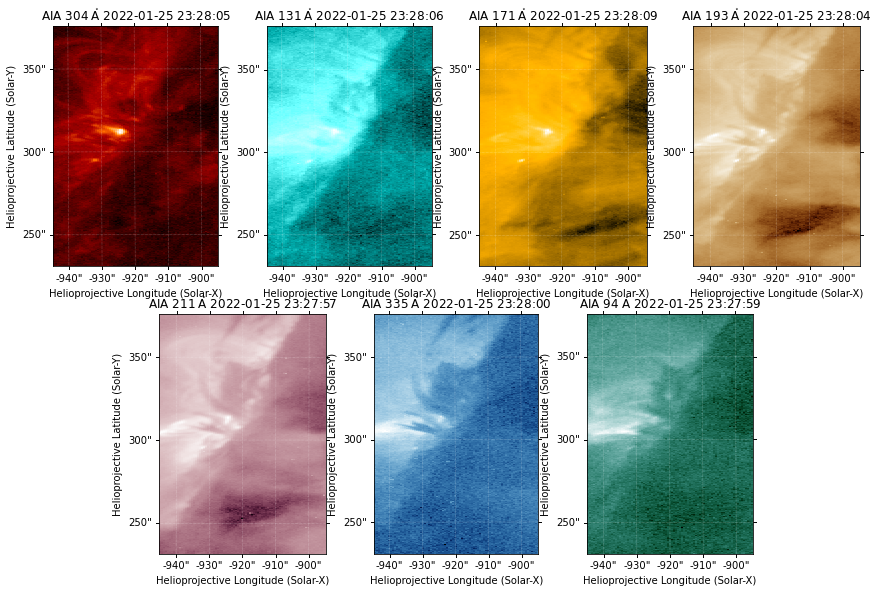

In [96]:
#Visualize the event to confirm the bounding box is fine

# TWEAK THESE:
bbox_add_left_deg = 4
bbox_add_right_deg = 4
bbox_add_up_deg = 3
bbox_add_down_deg = 3

#For data using hek results
#event_start = datetime.datetime.strptime(my_flare['event_starttime'], "%Y-%m-%dT%H:%M:%S")
#event_end = datetime.datetime.strptime(my_flare['event_endtime'], "%Y-%m-%dT%H:%M:%S")

#For data using custom time interval
event_start = datetime.datetime.strptime(starttimeT, "%Y-%m-%dT%H:%M:%S")
event_end = datetime.datetime.strptime(endtimeT, "%Y-%m-%dT%H:%M:%S")

event_length = event_end - event_start

top_right = SkyCoord(my_flare["boundbox_c1ur"] + bbox_add_right_deg , my_flare["boundbox_c2ur"] + 
                     bbox_add_up_deg, unit="deg", frame=sunpy.coordinates.frames.HeliographicStonyhurst)

bottom_left = SkyCoord(my_flare["boundbox_c1ll"] - bbox_add_left_deg, my_flare["boundbox_c2ll"] - 
                       bbox_add_down_deg, unit="deg", frame=sunpy.coordinates.frames.HeliographicStonyhurst)

mymaps = sunpy.map.Map([f[0] for f in binnedFiles])

submaps = [mymap.submap(bottom_left, top_right=top_right) for mymap in mymaps]

idx_time = datetime.datetime.strptime(TimeFromFilename(binnedFiles[0][0]), "%Y-%m-%dT%H%M%S")

fig, ax = plt.subplots(figsize=(15,15))

ax1 = plt.subplot2grid((3,8), (1,0), colspan=2, projection=submaps[0])
ax2 = plt.subplot2grid((3,8), (1,2), colspan=2, projection=submaps[1])
ax3 = plt.subplot2grid((3,8), (1,4), colspan=2, projection=submaps[2])
ax4 = plt.subplot2grid((3,8), (1,6), colspan=2, projection=submaps[3])
ax5 = plt.subplot2grid((3,8), (2,1), colspan=2, projection=submaps[4])
ax6 = plt.subplot2grid((3,8), (2,3), colspan=2, projection=submaps[5])
ax7 = plt.subplot2grid((3,8), (2,5), colspan=2, projection=submaps[6])

axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

for m_idx, m in enumerate(submaps):
    m.plot(axes=axes_list[m_idx], aspect=0.5)

#fig.tight_layout(h_pad=0.05,w_pad=2.5)
#fig.show()

# Cutout Only the Necessary Data

In [97]:
#Once we have a good bounding box around the flare, we can request only that specific cutout of the sun from JSOC
cutout = a.jsoc.Cutout(
    submaps[0].bottom_left_coord,
    submaps[0].top_right_coord,
    tracking=True)

#For calculated start/end times
#cutout_res = Fido.search(
#    a.Time(my_flare["event_starttime"], my_flare["event_endtime"]),
#    a.jsoc.Notify(jsoc_email), a.jsoc.Series('aia.lev1_euv_12s'),
#    a.jsoc.Segment.image,
#    cutout,)

#For custom time intervals
cutout_res = Fido.search(
    a.Time(starttime, endtime),
    a.jsoc.Notify(jsoc_email), a.jsoc.Series('aia.lev1_euv_12s'),
    a.jsoc.Segment.image,
    cutout,)

cutout_res.show()

T_REC,T_OBS,WAVELNTH,DATE,FSN,EXPTIME,QUALITY,ORIGIN,TELESCOP,INSTRUME,DATE__OBS,DATE-OBS,CAMERA,IMG_TYPE,EXPSDEV,INT_TIME,WAVEUNIT,WAVE_STR,FID,QUALLEV0,TOTVALS,DATAVALS,MISSVALS,PERCENTD,DATAMIN,DATAMAX,DATAMEDN,DATAMEAN,DATARMS,DATASKEW,DATAKURT,DATACENT,DATAP01,DATAP10,DATAP25,DATAP75,DATAP90,DATAP95,DATAP98,DATAP99,NSATPIX,OSCNMEAN,OSCNRMS,FLAT_REC,NSPIKES,CTYPE1,CUNIT1,CRVAL1,CDELT1,CRPIX1,CTYPE2,CUNIT2,CRVAL2,CDELT2,CRPIX2,CROTA2,R_SUN,MPO_REC,INST_ROT,IMSCL_MP,X0_MP,Y0_MP,ASD_REC,SAT_Y0,SAT_Z0,SAT_ROT,ACS_MODE,ACS_ECLP,ACS_SUNP,ACS_SAFE,ACS_CGT,ORB_REC,DSUN_REF,DSUN_OBS,RSUN_REF,RSUN_OBS,GAEX_OBS,GAEY_OBS,GAEZ_OBS,HAEX_OBS,HAEY_OBS,HAEZ_OBS,OBS_VR,OBS_VW,OBS_VN,CAR_ROT,CRLT_OBS,CRLN_OBS,HGLN_OBS,HGLT_OBS,ROI_NWIN,CALVER32,ROI_SUM,ROI_NAX1,ROI_NAY1,ROI_LLX1,ROI_LLY1,ROI_NAX2,ROI_NAY2,ROI_LLX2,ROI_LLY2,PIXLUNIT,DN_GAIN,EFF_AREA,EFF_AR_V,TEMPCCD,TEMPGT,TEMPSMIR,TEMPFPAD,ISPSNAME,ISPPKTIM,ISPPKTVN,AIVNMST,AIMGOTS,ASQHDR,ASQTNUM,ASQFSN,AIAHFSN,AECDELAY,AIAECTI,AIASEN,AIFDBID,AIMGOTSS,AIFCPS,AIFTSWTH,AIFRMLID,AIFTSID,AIHISMXB,AIHIS192,AIHIS348,AIHIS604,AIHIS860,AIFWEN,AIMGSHCE,AECTYPE,AECMODE,AISTATE,AIAECENF,AIFILTYP,AIMSHOBC,AIMSHOBE,AIMSHOTC,AIMSHOTE,AIMSHCBC,AIMSHCBE,AIMSHCTC,AIMSHCTE,AICFGDL1,AICFGDL2,AICFGDL3,AICFGDL4,AIFOENFL,AIMGFSN,AIMGTYP,AIAWVLEN,AIAGP1,AIAGP2,AIAGP3,AIAGP4,AIAGP5,AIAGP6,AIAGP7,AIAGP8,AIAGP9,AIAGP10,AGT1SVY,AGT1SVZ,AGT2SVY,AGT2SVZ,AGT3SVY,AGT3SVZ,AGT4SVY,AGT4SVZ,AIMGSHEN,KEYWDDOC,LVL_NUM,T_REC_step,T_REC_epoch
str20,str23,int64,str20,int64,float64,int64,str12,str7,str5,str23,str23,int64,str5,float64,float64,str8,str8,int64,int64,int64,int64,int64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,str20,int64,str8,str6,float64,float64,float64,str8,str6,float64,float64,float64,float64,float64,str30,float64,float64,float64,float64,str29,float64,float64,float64,str7,str2,str3,str2,str3,str46,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,str17,str23,str7,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str2,str6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str74,float64,float64,str23
2022-01-25T23:27:59Z,2022-01-25T23:28:00.57Z,94,2022-01-31T15:10:53Z,249580893,2.900807,0,SDO/JSOC-SDP,SDO/AIA,AIA_4,2022-01-25T23:27:59.12Z,2022-01-25T23:27:59.12Z,4,LIGHT,0.000174,3.164062,angstrom,94_THIN,0,0,16777216,16777216,0,100.0,-8,551,1,1.9535,3.55,17.3,868.15,1.63,-1.0,0.0,1.0,4.0,6.0,7.0,10.0,14.0,0,--,--,aia.flatfield[:#639],35504,HPLN-TAN,arcsec,0.0,0.600109,2071.042969,HPLT-TAN,arcsec,0.0,0.600109,2008.066895,-0.137584,1624.456543,aia.master_pointing3h[:#46570],-0.13761,0.600109,2070.042969,2007.066895,sdo.lev0_asd_0004[:#94557796],3.620198,10.158545,2.6e-05,SCIENCE,NO,YES,NO,GT3,sdo.fds_orbit_vectors[2022.01.25_23:28:00_UTC],149597870691.0,147264394883.44,696000000.0,974.85098,35014053.08,-937553.46,-23467930.35,-85847440405.45,119653742665.51,-29023385.0,2824.018326,29177.157955,-3735.278542,2253,-5.550621,173.617035,-0.011566,-5.550621,--,--,--,--,--,--,--,--,--,--,--,DN,18.3,0.282,3.0,-71.0,21.013,41.267,21.066,aia.lev0_isp_0011,2022-01-25T23:27:57.51Z,001.197,453,2021844517,3470806365,3,249580893,249580885,1535,0,0,241,12974,4,0,3337,40960,7,0,8348458,8386292,8388608,270,2900,0,ON,CLOSED,1,0,40.476002,25.375999,54.287998,67.800003,2940.991943,2926.219971,2955.184082,2968.771973,0,23,87,236,1,7,0,9,0,0,0,0,0,0,0,279,343,748,-5,-9,-11,-15,-1,0,56,123,4,https://www.lmsal.com/sdodocs/doc?cmd

# Datacube Creation

In [98]:
#Fetch the cutouts
cutout_downloaded_files = Fido.fetch(cutout_res)

Export request pending. [id=JSOC_20220620_706, status=2]
Waiting for 0 seconds...
Export request pending. [id=JSOC_20220620_706, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220620_706, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220620_706, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220620_706, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220620_706, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220620_706, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220620_706, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220620_706, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220620_706, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220620_706, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220620_706, status=1]
Waiting for 5 seconds...
Export request p

Files Downloaded:   0%|          | 0/357 [00:00<?, ?file/s]

aia.lev1_euv_12s.2022-01-25T232759Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232759Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232759Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232759Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232759Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232759Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232759Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232811Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232811Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232811Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232811Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232811Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232811Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232811Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232823Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232823Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232823Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232823Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232823Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232823Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232823Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232835Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232835Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232835Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232835Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232835Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232835Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232835Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232847Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232847Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232847Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232847Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232847Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232847Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232847Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232859Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232859Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232859Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232859Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232859Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232859Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232859Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232911Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232911Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232911Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232911Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232911Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232911Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232911Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232923Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232923Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232923Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232923Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232923Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232923Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232923Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232935Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232935Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232935Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232935Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232935Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232935Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232935Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232947Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232947Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232947Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232947Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232947Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232947Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232947Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232959Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232959Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232959Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232959Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232959Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232959Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T232959Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233011Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233011Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233011Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233011Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233011Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233011Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233011Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233023Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233023Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233023Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233023Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233023Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233023Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233023Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233035Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233035Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233035Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233035Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233035Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233035Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233035Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233047Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233047Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233047Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233047Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233047Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233047Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233047Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233059Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233059Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233059Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233059Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233059Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233059Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233059Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233111Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233111Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233111Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233111Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233111Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233111Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233111Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233123Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233123Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233123Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233123Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233123Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233123Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233123Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233135Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233135Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233135Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233135Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233135Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233135Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233135Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233147Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233147Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233147Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233147Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233147Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233147Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233147Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233159Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233159Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233159Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233159Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233159Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233159Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233159Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233211Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233211Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233211Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233211Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233211Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233211Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233211Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233223Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233223Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233223Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233223Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233223Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233223Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233223Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233235Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233235Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233235Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233235Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233235Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233235Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233235Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233247Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233247Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233247Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233247Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233247Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233247Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233247Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233259Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233259Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233259Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233259Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233259Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233259Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233259Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233311Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233311Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233311Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233311Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233311Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233311Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233311Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233323Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233323Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233323Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233323Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233323Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233323Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233323Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233335Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233335Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233335Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233335Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233335Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233335Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233335Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233347Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233347Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233347Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233347Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233347Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233347Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233347Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233359Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233359Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233359Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233359Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233359Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233359Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233359Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233411Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233411Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233411Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233411Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233411Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233411Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233411Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233423Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233423Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233423Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233423Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233423Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233423Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233423Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233435Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233435Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233435Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233435Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233435Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233435Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233435Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233447Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233447Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233447Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233447Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233447Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233447Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233447Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233459Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233459Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233459Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233459Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233459Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233459Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233459Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233511Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233511Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233511Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233511Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233511Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233511Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233511Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233523Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233523Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233523Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233523Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233523Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233523Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233523Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233535Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233535Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233535Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233535Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233535Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233535Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233535Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233547Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233547Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233547Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233547Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233547Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233547Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233547Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233559Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233559Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233559Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233559Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233559Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233559Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233559Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233611Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233611Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233611Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233611Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233611Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233611Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233611Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233623Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233623Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233623Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233623Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233623Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233623Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233623Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233635Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233635Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233635Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233635Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233635Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233635Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233635Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233647Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233647Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233647Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233647Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233647Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233647Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233647Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233659Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233659Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233659Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233659Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233659Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233659Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233659Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233711Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233711Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233711Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233711Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233711Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233711Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233711Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233723Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233723Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233723Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233723Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233723Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233723Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233723Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233735Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233735Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233735Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233735Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233735Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233735Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233735Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233747Z.94.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233747Z.131.image.fits:   0%|          | 0.00/40.3k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233747Z.171.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233747Z.193.image.fits:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233747Z.211.image.fits:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233747Z.304.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-25T233747Z.335.image.fits:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

In [99]:
#Check for errors in the cutouts
cutout_downloaded_files.errors

[]

In [100]:
#Bin the files
binnedFiles = [[], [], [], [], [], [], []]

for file in cutout_downloaded_files:
    wav = WavelengthFromFilename(file)
    
    #Skip if it is a spike file
    if wav == -1:
        continue
    
    #Otherwise bin it
    binnedFiles[wavelengthIndexDict[wav]].append(file)
    
#Now also sort each bin by time
for wav_bin in binnedFiles:
    wav_bin.sort()

In [106]:
#Our data is binned by wavelength, then the 2nd axis is time. Flip it so we bin time first
binnedFilesT = np.array(binnedFiles).T

#Figure out the size of the data cube
array_tuple = binnedFilesT.shape
m = sunpy.map.Map(binnedFilesT[0, 0]).data.T.shape
array_tuple = array_tuple + m

#Generate filename as outlined in fileformat.txt
#filename = "flare_" + my_flare["event_starttime"].replace(":", "") + '_' + str(array_tuple[0]) + '_' + str(array_tuple[1]) + '_' + str(array_tuple[2]) + '_' + str(array_tuple[3]) + '.fits'
filename = "flare_" + starttimeT.replace(":", "_") + '.fits'

out_arr = np.zeros(array_tuple, dtype=np.int16)

for t_idx, time_bin in enumerate(binnedFilesT):
    for idx, wavelength in enumerate(time_bin):
        m = sunpy.map.Map(wavelength)

        out_arr[t_idx, idx] = m.data.T

astropy.io.fits.writeto(filename, out_arr)

# Loading a Datacube

In [107]:
from ast import literal_eval as make_tuple

#Function to load the datacube
def load_datacube(filename):    
    return astropy.io.fits.getdata(filename)

#Copy and paste filename into command below
print(filename)

flare_2022-1-25T23_28_00.fits


In [108]:
#Loading datacube from specific file
new_data = load_datacube('C:/Users/hharn/Desktop/Semester 6- Spring 2022/PHYS 299/flare_2022-1-25T23_28_00.fits')

In [109]:
#Now we can use list slicing on it.
#The example below specifically is all the times, the 0th wavelength and 0, 0 pixel from bottom left
#A time series, if you will :)

#The array new_data is organized by [t,λ,x,y]
print(new_data[:,0,0,0])

[15 15 17 13 20 17 18 14 15 25 18 18 14 16 20 19 20 18 23 20 20 16 17 17
 20 19 21 20 20 18 22 18 13 15 20 16 16 25 17 12 20 18 13 18 14 15 23 14
 20 15 24]


# Graphing Intensity as Time Series

Flare Peak Time: 2022-01-25T23:49:00


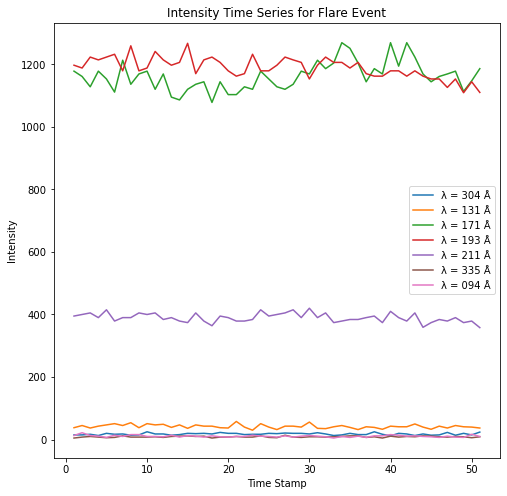

In [110]:
import matplotlib.pyplot as plt
#Printing the intensities at each wavelengths
#for k in range(0,7):
#    print(k,':', new_data[:,k,0,0])

#Appending a simple list for time for plotting, will be updated if needed
t = []
i = 0
for i in range(0,len(new_data[:,0,0,0])):
    i = i + 1
    t.append(i)

wavelengths = ['304 Å', '131 Å', '171 Å', '193 Å', '211 Å', '335 Å', '094 Å']
    
#This plots all 7 graphs at once, without labels to distinguish them yet
print('Flare Peak Time:', my_flare["event_peaktime"])
for z in range(0,7):
    name = 'λ = ' + wavelengths[z]
    plt.plot(t,new_data[:,z,0,0], label = name)
    plt.xlabel('Time Stamp')
    plt.ylabel('Intensity')
    plt.legend()
    plt.title('Intensity Time Series for Flare Event')

#This plots just one wavelength
#plt.plot(t,new_data[:,0,0,0])
#plt.xlabel('Time Stamp')
#plt.ylabel('Intensity')
#plt.title('Intensity Time Series for --- Å')

plt.show()

# Topological Data Analysis

In [111]:
import numpy as np
import plotly.graph_objects as go

#Simply graphing the time series data
fig = go.Figure(data=go.Scatter(x=t, y=new_data[:,0,0,0]))
fig.update_layout(xaxis_title="Timestamp", yaxis_title="Amplitude")
fig.show()

# Embedding the Data

In [112]:
from gtda.time_series import SingleTakensEmbedding
from gtda.plotting import plot_point_cloud

#Define axes as how many dimensions you want the embedded data 
axes = 2

#Embedding the data
embedder_periodic = SingleTakensEmbedding(
    parameters_type = "fixed", n_jobs = 2, time_delay = 8, dimension = axes, stride = 10,)

embedded_data = embedder_periodic.fit_transform(new_data[:,0,0,0])

#Comparing length of data to embedded data
print('Number of Data Points: ', len(new_data[:,0,0,0]))
print('Number of Embedded Data Points: ', len(embedded_data))

print(f"Shape of embedded time series: {embedded_data.shape}")

#Plotting embedded data
plot_point_cloud(embedded_data)

Number of Data Points:  51
Number of Embedded Data Points:  5
Shape of embedded time series: (5, 2)


# Persistent Homology

In [113]:
from gtda.homology import VietorisRipsPersistence

#Comverting the embedded data into useful persistence data
persistence_data = embedded_data[None, :, :]

#0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1, 2]

periodic_persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=6)

#Grahing a persistence plot
periodic_persistence.fit_transform_plot(persistence_data)
plt.show()